<h1>Airbnb listing data for NYC 2019</h1>

<p>Airbnb is one of the largest short-term rental services in the world.  As such, they have millions of listings, many of which are in metropolitan areas like LA and NYC.  They currently do not have a public API to get listing data, but fortunately a recent <a href=https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data>dataset</a> is available on Kaggle specifically for NYC, and the raw source for this data can be found <a href="http://data.insideairbnb.com/united-states/ny/new-york-city/2019-12-04/data/listings.csv.gz">here</a>.  Data for other cities can also be found <a href="http://insideairbnb.com/get-the-data.html">here</a>.</p>

<p>Let's take a look at the <b>listings.csv</b> first, then we'll get to the time series data in <b>calendar.csv</b>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

%matplotlib inline
listings_df = pd.read_csv('listings.csv')

/Users/blai/miniconda3/envs/capstone/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (61,62,94,95) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


<br/>
<p>There are certain columns that have mixed data. Lets take a look at the general structure of the listings as well as those columns.</p>

In [2]:
print(listings_df.info())
print(listings_df.columns)
for col_index in [60, 61, 93, 94]:
    print(listings_df.columns[col_index])
listings_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50599 entries, 0 to 50598
Columns: 106 entries, id to reviews_per_month
dtypes: float64(22), int64(21), object(63)
memory usage: 40.9+ MB
None
Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       ...
       'instant_bookable', 'is_business_travel_ready', 'cancellation_policy',
       'require_guest_profile_picture', 'require_guest_phone_verification',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'reviews_per_month'],
      dtype='object', length=106)
price
weekly_price
requires_license
license


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2595,https://www.airbnb.com/rooms/2595,20191204162729,2019-12-07,Skylit Midtown Castle,"Beautiful, spacious skylit studio in the heart...","- Spacious (500+ft²), immaculate and nicely fu...","Beautiful, spacious skylit studio in the heart...",none,Centrally located in the heart of Manhattan ju...,...,f,f,strict_14_with_grace_period,t,t,1,1,0,0,0.39
1,3831,https://www.airbnb.com/rooms/3831,20191204162729,2019-12-07,Cozy Entire Floor of Brownstone,Urban retreat: enjoy 500 s.f. floor in 1899 br...,Greetings! We own a double-duplex brownst...,Urban retreat: enjoy 500 s.f. floor in 1899 br...,none,Just the right mix of urban center and local n...,...,f,f,moderate,f,f,1,1,0,0,4.67
2,5099,https://www.airbnb.com/rooms/5099,20191204162729,2019-12-06,Large Cozy 1 BR Apartment In Midtown East,My large 1 bedroom apartment has a true New Yo...,I have a large 1 bedroom apartment centrally l...,My large 1 bedroom apartment has a true New Yo...,none,My neighborhood in Midtown East is called Murr...,...,f,f,moderate,t,t,1,1,0,0,0.60
3,5121,https://www.airbnb.com/rooms/5121,20191204162729,2019-12-06,BlissArtsSpace!,NaN,HELLO EVERYONE AND THANKS FOR VISITING BLISS A...,HELLO EVERYONE AND THANKS FOR VISITING BLISS A...,none,NaN,...,f,f,strict_14_with_grace_period,f,f,1,0,1,0,0.38
4,5178,https://www.airbnb.com/rooms/5178,20191204162729,2019-12-05,Large Furnished Room Near B'way,Please don’t expect the luxury here just a bas...,"You will use one large, furnished, private roo...",Please don’t expect the luxury here just a bas...,none,"Theater district, many restaurants around here.",...,f,f,strict_14_with_grace_period,f,f,1,0,1,0,3.52


<br/>
<p>As we will see later, those mixed columns are not necessary.  There are also more entries than in the first dataset that we looked at (hopefully for more accurate modeling).  Let's drop the mixed columns and other columns that have irrelevant data, majority incomplete data, or data that can be found in other tables.</p>

In [3]:
# calendar values scraped in a small window between 2019-12-04 and 2019-12-07

listings_clean = listings_df.drop(['listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', \
    'description', 'experiences_offered', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', \
    'house_rules', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', \
    'host_name', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', \
    'host_acceptance_rate', 'host_since', 'host_listings_count', 'host_total_listings_count', \
    'host_verifications', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_has_profile_pic', \
    'host_identity_verified', 'host_neighbourhood', 'street', 'neighbourhood', 'city', 'state', 'zipcode', \
    'market', 'smart_location', 'country_code', 'country', 'is_location_exact', 'instant_bookable', \
    'is_business_travel_ready', 'license', 'jurisdiction_names', 'review_scores_value', 'requires_license', \
    'review_scores_communication', 'bed_type', 'amenities', 'weekly_price', 'monthly_price', \
    'security_deposit', 'guests_included', 'minimum_minimum_nights', 'maximum_minimum_nights', \
    'minimum_maximum_nights', 'maximum_maximum_nights', 'calendar_updated', 'has_availability', \
    'calendar_last_scraped', 'number_of_reviews_ltm', 'first_review', 'last_review', 'review_scores_accuracy', \
    'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_location', 'cancellation_policy', \
    'require_guest_profile_picture', 'require_guest_phone_verification', 'calculated_host_listings_count', \
    'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', \
    'calculated_host_listings_count_shared_rooms', 'cleaning_fee', 'extra_people', \
    'number_of_reviews', 'review_scores_rating', 'square_feet', 'property_type', 'minimum_nights_avg_ntm', \
    'maximum_nights_avg_ntm', 'price', 'minimum_nights', 'maximum_nights', 'availability_30', \
    'availability_60', 'availability_90', 'availability_365'], axis=1)
print(listings_clean.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50599 entries, 0 to 50598
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            50599 non-null  int64  
 1   neighbourhood_cleansed        50599 non-null  object 
 2   neighbourhood_group_cleansed  50599 non-null  object 
 3   latitude                      50599 non-null  float64
 4   longitude                     50599 non-null  float64
 5   room_type                     50599 non-null  object 
 6   accommodates                  50599 non-null  int64  
 7   bathrooms                     50548 non-null  float64
 8   bedrooms                      50536 non-null  float64
 9   beds                          50467 non-null  float64
 10  reviews_per_month             40379 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 4.2+ MB
None


<br/>
<p>Columns <b>bathrooms, bedrooms, beds</b> have missing data, but thankfully not a lot.  We will try to clean that up.  Let's also rename a couple columns</p>

In [4]:
listings_clean.rename(columns={
    'neighbourhood_cleansed':'neighbourhood',
    'neighbourhood_group_cleansed': 'neighbourhood_group'
}, inplace=True)
listings_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50599 entries, 0 to 50598
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   50599 non-null  int64  
 1   neighbourhood        50599 non-null  object 
 2   neighbourhood_group  50599 non-null  object 
 3   latitude             50599 non-null  float64
 4   longitude            50599 non-null  float64
 5   room_type            50599 non-null  object 
 6   accommodates         50599 non-null  int64  
 7   bathrooms            50548 non-null  float64
 8   bedrooms             50536 non-null  float64
 9   beds                 50467 non-null  float64
 10  reviews_per_month    40379 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 4.2+ MB


<br/>
<p>Since the large majority of listings are homes/apts or private rooms, let's keep those listings.</p>

In [5]:
print(listings_clean.room_type.value_counts())
listings_clean = listings_clean.loc[
    (listings_clean.room_type == 'Entire home/apt') |
    (listings_clean.room_type == 'Private room')
]

Entire home/apt    26141
Private room       22785
Shared room         1256
Hotel room           417
Name: room_type, dtype: int64


<br/>
<p>We see some possible outliers for <b>accommodates, bathrooms, bedrooms, beds</b>.</p>

In [6]:
listings_clean.describe()

,id,latitude,longitude,accommodates,bathrooms,bedrooms,beds,reviews_per_month
count,4.892600e+04,48926.000000,48926.000000,48926.000000,48879.000000,48863.000000,48798.000000,39182.000000
mean,2.117010e+07,40.728622,-73.950841,2.890161,1.147538,1.187872,1.548260,1.401085
std,1.242617e+07,0.054921,0.047503,1.910505,0.427225,0.771793,1.124263,1.670326
min,2.595000e+03,40.499790,-74.247870,1.000000,0.000000,0.000000,0.000000,0.010000
25%,9.977018e+06,40.689350,-73.982800,2.000000,1.000000,1.000000,1.000000,0.190000
50%,2.127600e+07,40.722460,-73.955020,2.000000,1.000000,1.000000,1.000000,0.730000
75%,3.244168e+07,40.762940,-73.934270,4.000000,1.000000,1.000000,2.000000,2.120000
max,4.058402e+07,40.916860,-73.712990,25.000000,15.500000,21.000000,40.000000,19.950000


<br/>
<p>Check for duplicate latitude and longitude value pairs, which most likely means duplicate listings</p>

In [7]:
# https://stackoverflow.com/questions/44481768/remove-duplicate-rows-from-pandas-dataframe-where-only-some-columns-have-the-sam
# https://stackoverflow.com/questions/16167829/in-pandas-how-can-i-reset-index-without-adding-a-new-column

listings_clean = listings_clean.drop_duplicates(subset=['latitude', 'longitude']).reset_index(drop=True)
listings_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48914 entries, 0 to 48913
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   48914 non-null  int64  
 1   neighbourhood        48914 non-null  object 
 2   neighbourhood_group  48914 non-null  object 
 3   latitude             48914 non-null  float64
 4   longitude            48914 non-null  float64
 5   room_type            48914 non-null  object 
 6   accommodates         48914 non-null  int64  
 7   bathrooms            48867 non-null  float64
 8   bedrooms             48851 non-null  float64
 9   beds                 48786 non-null  float64
 10  reviews_per_month    39172 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 4.1+ MB


<br/>
<p>Look at non-numerical columns to see if they can be categorized.</p>

In [8]:
# http://benalexkeen.com/mapping-categorical-data-in-pandas/

print(listings_clean.room_type.value_counts())
print(listings_clean.neighbourhood_group.value_counts())
print(listings_clean.neighbourhood.value_counts())


Entire home/apt    26134
Private room       22780
Name: room_type, dtype: int64
Manhattan        21255
Brooklyn         20194
Queens            5943
Bronx             1149
Staten Island      373
Name: neighbourhood_group, dtype: int64
Williamsburg                  3903
Bedford-Stuyvesant            3823
Harlem                        2691
Bushwick                      2431
Upper West Side               1935
                              ... 
Willowbrook                      1
Bay Terrace, Staten Island       1
Country Club                     1
Woodrow                          1
Fort Wadsworth                   1
Name: neighbourhood, Length: 223, dtype: int64


In [9]:
home_listings = listings_clean.loc[listings_clean.room_type == 'Entire home/apt']
print(home_listings.bedrooms.value_counts())
print(home_listings.beds.value_counts())
print(home_listings.bathrooms.value_counts())

1.0     13018
2.0      6214
0.0      4140
3.0      2034
4.0       476
5.0       133
6.0        41
7.0        17
8.0        10
10.0        5
9.0         4
21.0        1
14.0        1
12.0        1
Name: bedrooms, dtype: int64
1.0     11605
2.0      8097
3.0      3258
4.0      1428
0.0       697
5.0       521
6.0       243
7.0       104
8.0        54
9.0        36
10.0       16
11.0       14
12.0       11
13.0        7
14.0        4
16.0        3
18.0        2
17.0        2
15.0        1
26.0        1
40.0        1
21.0        1
22.0        1
Name: beds, dtype: int64
1.0     22189
2.0      2255
1.5       889
2.5       339
3.0       208
3.5        77
4.0        49
0.0        37
0.5        26
4.5        23
5.0        13
6.0         5
5.5         4
7.0         2
8.0         1
7.5         1
6.5         1
15.5        1
Name: bathrooms, dtype: int64


<p>We see some outliers that may skew any modeling, so let's remove any listing over 10 <b>bedrooms</b>, 12 <b>beds</b>, and 5 <b>bathrooms</b>.  Realistically the vast majority of property owners are not listing super mansions.</p>

In [10]:
# listings_clean = listings_clean.loc[
#     (listings_clean.bedrooms <= 10) & (listings_clean.beds <=12) & (listings_clean.bathrooms <= 5)
# ]

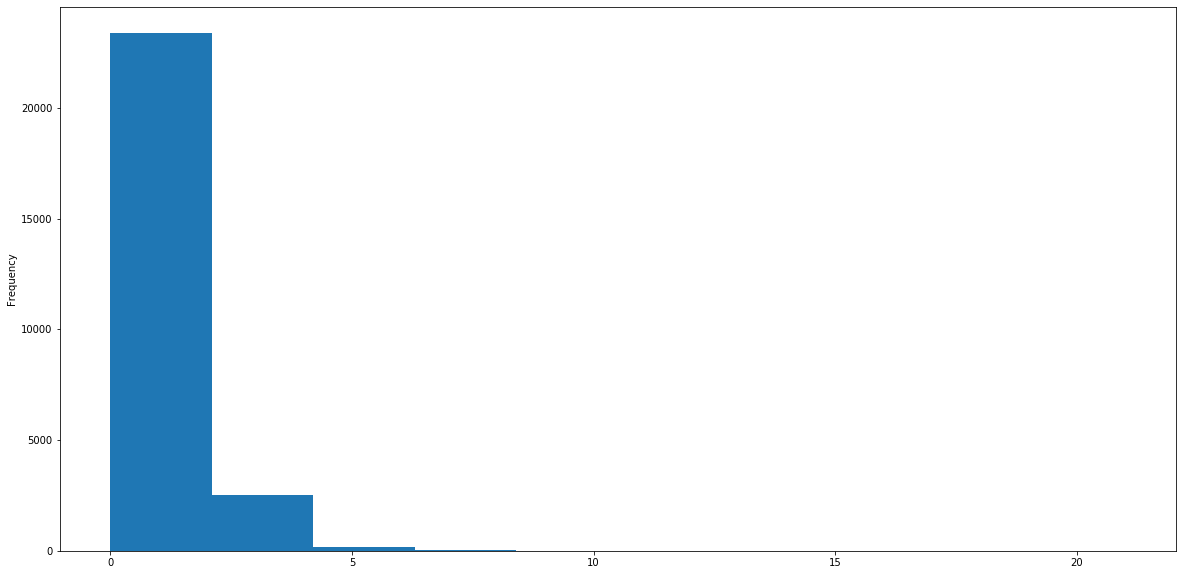

In [10]:
home_listings.bedrooms.plot(kind='hist', figsize=(20, 10))

<p>Home listings are heavily skewed toward single bedroom.  Perhaps we can approximate <b>bedrooms, bathrooms, beds</b> as exponential distributions.</p>
<p>Let's do the same analysis for single room type listings</p>

In [12]:
room_listings = listings_clean.loc[listings_clean.room_type != 'Entire home/apt']
print(room_listings.bedrooms.value_counts())
print(room_listings.beds.value_counts())
print(room_listings.bathrooms.value_counts())

1.0     21549
2.0       563
0.0       457
3.0       123
4.0        44
6.0        11
5.0         7
11.0        1
8.0         1
Name: bedrooms, dtype: int64
1.0     19119
2.0      2300
0.0       656
3.0       409
4.0       134
5.0        28
6.0        16
7.0         8
8.0         4
11.0        1
21.0        1
10.0        1
9.0         1
12.0        1
Name: beds, dtype: int64
1.0    19034
2.0     1723
1.5     1490
3.0      151
2.5      132
0.0       75
0.5       74
4.0       42
3.5       13
6.0        5
5.0        4
6.5        2
7.0        1
4.5        1
Name: bathrooms, dtype: int64


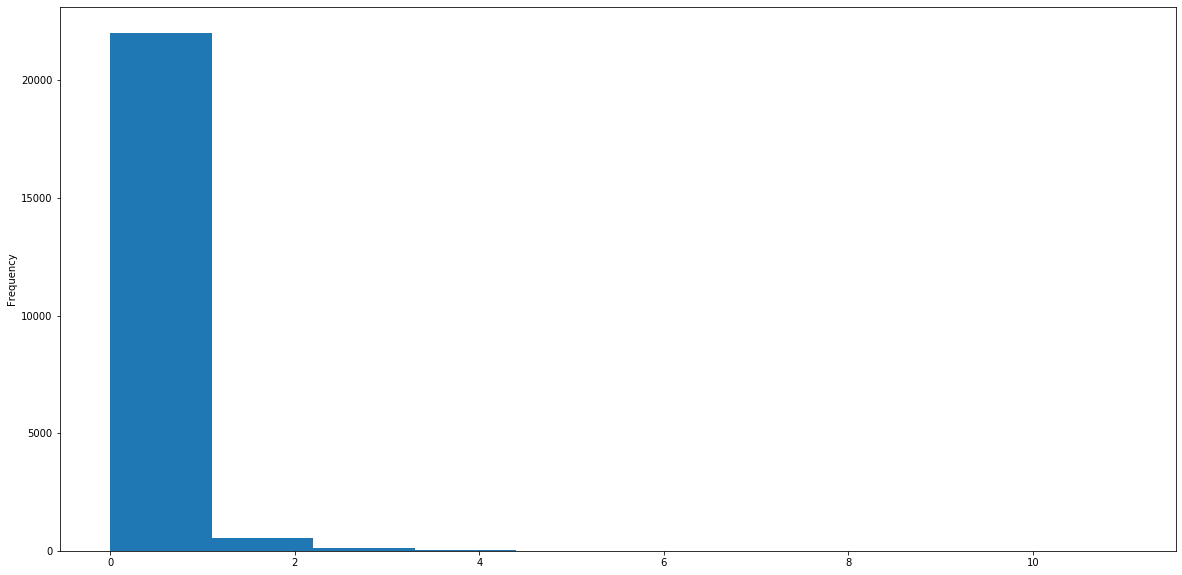

In [13]:
room_listings.bedrooms.plot(kind='hist', figsize=(20, 10))

<p>We get similar results to home listings, which is odd.  Perhaps some single room type listings were incorrectly listed.  That means we may not be able to rely on <b>room_type</b> as a factor in filling in any missing bedroom and bathroom values.</p>

<p>Let's do some data cleaning by filling in the missing <b>bedrooms, bathrooms, beds</b> values (disregarding homes/apts vs. single room since <b>room_type</b> is not always indicative of multiple rooms vs. one room).  0 values can still be considered valid (e.g. studio apt, shared living area, shared bathroom, non-bed type sleeping arrangment).  We will assume that 0.001 degree latitude or longitude <a href=https://gizmodo.com/how-precise-is-one-degree-of-longitude-or-latitude-1631241162">is about 100 m</a>.  Let's average over an area of 200 m radius from listings that have missing data.  We will group by <b>neighbourhood</b> when calculating the mean.</p>

In [18]:
lat_diff = 0.002
long_diff = 0.002
def avg_of_neighbors(row, col_name, col_index):
    item = row[col_index]
    room_type = row[5]
    lat = row[3]
    long = row[4]
    if math.isnan(item):
        item = listings_clean[col_name].loc[(listings_clean.latitude > lat - lat_diff) \
            & (listings_clean.latitude < lat + lat_diff) \
            & (listings_clean.longitude > long - long_diff) \
            & (listings_clean.longitude < long + long_diff)].groupby(by=listings_clean.neighbourhood).mean().round()[0]
        if item == 0:
            item = 1
        row[col_index] = item
    return row

listings_clean = listings_clean.apply(avg_of_neighbors, col_name='bathrooms', col_index=7, axis=1)
listings_clean = listings_clean.apply(avg_of_neighbors, col_name='bedrooms', col_index=8, axis=1)
listings_clean = listings_clean.apply(avg_of_neighbors, col_name='beds', col_index=9, axis=1)

In [15]:
print(listings_clean.bedrooms.value_counts())
print(listings_clean.bathrooms.value_counts())
print(listings_clean.beds.value_counts())

1.0     34625
2.0      6780
0.0      4597
3.0      2157
4.0       520
5.0       140
6.0        52
7.0        17
8.0        11
10.0        5
9.0         4
12.0        1
14.0        1
21.0        1
11.0        1
Name: bedrooms, dtype: int64
1.0     41269
2.0      3979
1.5      2379
2.5       471
3.0       359
0.0       112
0.5       100
4.0        91
3.5        90
4.5        24
5.0        17
6.0        10
5.5         4
7.0         3
6.5         3
15.5        1
8.0         1
7.5         1
Name: bathrooms, dtype: int64
1.0     30798
2.0     10440
3.0      3677
4.0      1562
0.0      1353
5.0       549
6.0       259
7.0       112
8.0        58
9.0        37
10.0       17
11.0       15
12.0       12
13.0        7
14.0        4
16.0        3
17.0        2
18.0        2
21.0        2
15.0        1
22.0        1
40.0        1
26.0        1
Name: beds, dtype: int64


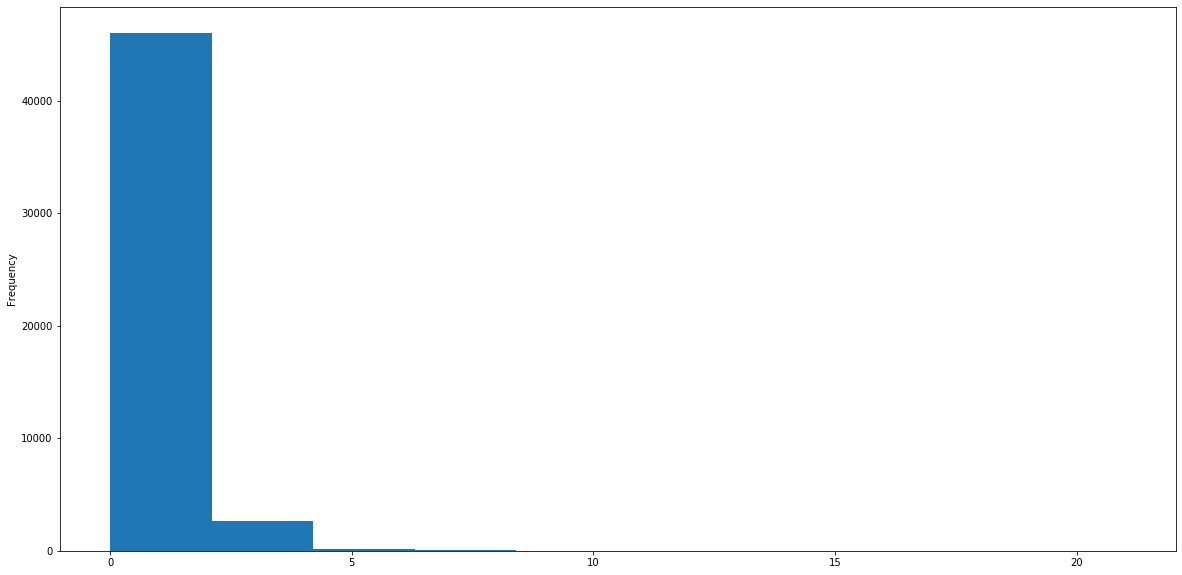

In [16]:
listings_clean.bedrooms.plot(kind='hist', figsize=(20, 10))

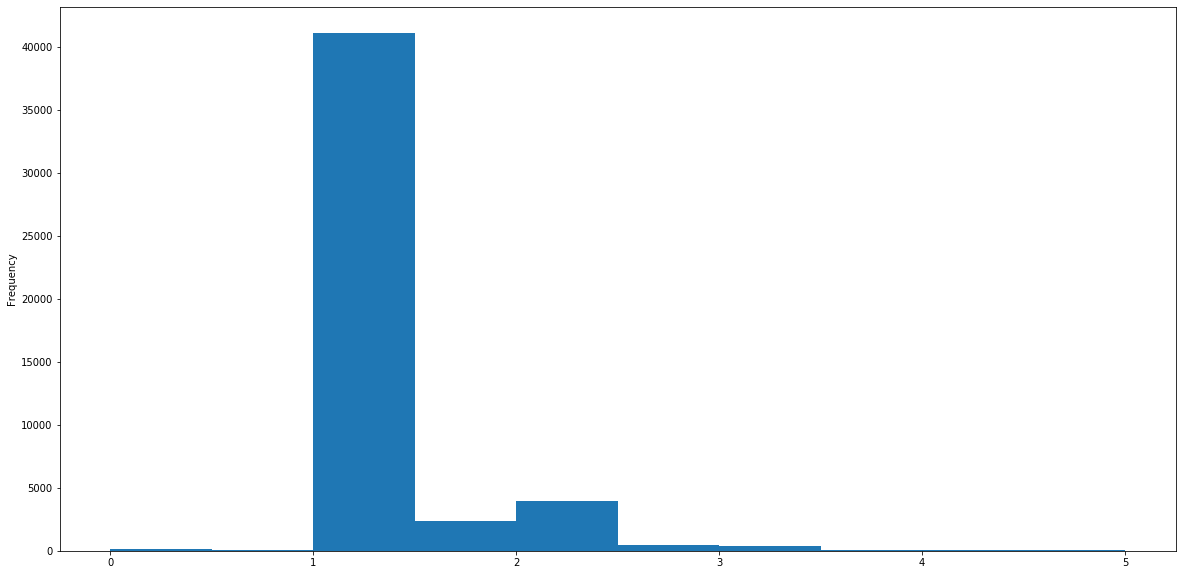

In [17]:
listings_clean.bathrooms.plot(kind='hist', figsize=(20, 10))

<p>After <b>bedrooms, bathrooms, beds</b> cleanup, we are able to see a bit more detail in the distributions.  They are approximately exponential (again skewed toward 1).</p>

<p>Final check on the listings for any missing data.</p>

In [17]:
listings_clean.info()
print(listings_clean.neighbourhood_group.value_counts())
print(listings_clean.neighbourhood.value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48914 entries, 0 to 48913
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   48914 non-null  int64  
 1   neighbourhood        48914 non-null  object 
 2   neighbourhood_group  48914 non-null  object 
 3   latitude             48914 non-null  float64
 4   longitude            48914 non-null  float64
 5   room_type            48914 non-null  object 
 6   accommodates         48914 non-null  int64  
 7   bathrooms            48914 non-null  float64
 8   bedrooms             48912 non-null  float64
 9   beds                 48913 non-null  float64
 10  reviews_per_month    39172 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 4.1+ MB
Manhattan        21255
Brooklyn         20194
Queens            5943
Bronx             1149
Staten Island      373
Name: neighbourhood_group, dtype: int64
Williamsburg            

<br/>
<p>Let's try to categorize the number of monthly reviews.  0 or NaN will be treated as no reviews, 0 - 3 will be few reviews, and greater than 3 will count as many reviews.</p>

In [53]:
listings_clean['no_reviews'] = np.where(
    (listings_clean.reviews_per_month == 0) |
    np.isnan(listings_clean.review_per_month), 1, 0)
listings_clean['few_reviews'] = np.where(
    (listings_clean.reviews_per_month > 0) &
    (listings_clean.reviews_per_month <= 3), 1, 0)
listings_clean['many_reviews'] = np.where(listings_clean.reviews_per_month > 3, 1, 0)
listings_clean = listings_clean.drop('reviews_per_month', axis=1)

<br/>
<p>Now let's take a look at the time series data for availability, price, and nights.  <a href=http://data.insideairbnb.com/united-states/ny/new-york-city/2019-12-04/data/calendar.csv.gz><b>Calendar.csv</b></a> comes from the same <a href="http://insideairbnb.com/get-the-data.html">source</a> as <b>listings.csv</b></p>.

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

%matplotlib inline
calendar_df = pd.read_csv('calendar.csv', parse_dates=['date'])

In [55]:
calendar_df.loc[calendar_df.price == 0]

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights


<br/>
<p>This time we don't have to deal with columns of mixed data, nor do we have a large number of columns like in the <b>listings_clean</b> table.  We do, however, have over 18 million entries, which makes sense given that this is time series data over a year for 50,000+ listings.  We will have to clean up availability and price.</p>

In [56]:
print(calendar_df.info())
print(calendar_df.columns)
calendar_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18470156 entries, 0 to 18470155
Data columns (total 7 columns):
 #   Column          Dtype         
---  ------          -----         
 0   listing_id      int64         
 1   date            datetime64[ns]
 2   available       object        
 3   price           object        
 4   adjusted_price  object        
 5   minimum_nights  float64       
 6   maximum_nights  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 986.4+ MB
None
Index(['listing_id', 'date', 'available', 'price', 'adjusted_price',
       'minimum_nights', 'maximum_nights'],
      dtype='object')


,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,19812,2019-12-05,f,$105.00,$105.00,3.0,90.0
1,2595,2019-12-06,f,$175.00,$175.00,10.0,1125.0
2,2595,2019-12-07,f,$175.00,$175.00,10.0,1125.0
3,2595,2019-12-08,f,$175.00,$175.00,10.0,1125.0
4,2595,2019-12-09,f,$175.00,$175.00,10.0,1125.0


<br/>
<p>On checking for equal distribution of all listings over the relevant time period (assumed for this step to be a year), we see a problem with <b>listing_id</b> 15268792.  Let's just remove it, since it is not worth the effort to build a year's worth of data for that one listing.</p>

In [57]:
print(calendar_df.listing_id.value_counts())
calendar_clean = calendar_df[calendar_df.listing_id != 15268792]


25512622    368
32678719    368
28138840    368
30069091    368
24285044    368
           ... 
27926502    365
18992796    365
21677053    365
30226855    365
15268792      6
Name: listing_id, Length: 50599, dtype: int64


<br/>
<p>Since this data set was captured in 2019, we must clean up dates that have year 2020.  Then drop any duplicate <b>listing_id, date</b> combos.  Then check that all days add up to a calendar year for each <b>listing_id</b>.</p>

In [58]:
# https://stackoverflow.com/questions/50674011/replace-the-year-in-pandas-datetime-column
# https://stackoverflow.com/questions/28773342/truncate-timestamp-column-to-hour-precision-in-pandas-dataframe

calendar_clean['date'] = calendar_clean['date'].mask(calendar_clean['date'].dt.year == 2020,
                            calendar_clean['date'] - pd.to_timedelta(365, unit='D') + pd.to_timedelta(12, unit='h'))
calendar_clean['date'] = calendar_clean['date'].dt.floor('D')

<ipython-input-58-9b6d71aa0642>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calendar_clean['date'] = calendar_clean['date'].mask(calendar_clean['date'].dt.year == 2020,
<ipython-input-58-9b6d71aa0642>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calendar_clean['date'] = calendar_clean['date'].dt.floor('D')


In [59]:
calendar_clean = calendar_clean.drop_duplicates(subset=['listing_id', 'date']).reset_index(drop=True)
print(calendar_clean.listing_id.value_counts())

327521      365
7756711     365
31877537    365
14961122    365
201992      365
           ... 
37055580    365
13186007    365
18549136    365
34646244    365
30226855    365
Name: listing_id, Length: 50598, dtype: int64


<br/>
<p>Verify that all listing_id values can be found in the <b>listings_clean</b> table.  If not, then remove rows with listing_id values don't exist in the other table.</p>

In [60]:
# https://stackoverflow.com/questions/28901683/pandas-get-rows-which-are-not-in-other-dataframe

ids_match = calendar_clean.listing_id.isin(listings_clean.id)
print(ids_match.value_counts())

True     17419625
False     1048645
Name: listing_id, dtype: int64


In [61]:
calendar_clean = calendar_clean[calendar_clean.listing_id.isin(listings_clean.id)]
calendar_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17419625 entries, 0 to 18468269
Data columns (total 7 columns):
 #   Column          Dtype         
---  ------          -----         
 0   listing_id      int64         
 1   date            datetime64[ns]
 2   available       object        
 3   price           object        
 4   adjusted_price  object        
 5   minimum_nights  float64       
 6   maximum_nights  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 1.0+ GB


<br/>
<p>Translate all <b>available</b> values to 1 (available) or 0 (unavailable).</p>

In [62]:
print(calendar_clean.available.value_counts())
calendar_clean['available'] = np.where(calendar_clean.available == 't', 1, 0)
print(calendar_clean.available.value_counts())

f    11877755
t     5541870
Name: available, dtype: int64
0    11877755
1     5541870
Name: available, dtype: int64


<br/>
<p>Less than 1% of the entries have <b>adjusted_price</b> not equal to <b>price</b>, but we will use <b>adjusted_price</b> anyway and clean it up to be numerical</p>

In [63]:
calendar_clean[calendar_clean.price != calendar_clean.adjusted_price]

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
8232,20734,2019-12-06,0,$134.00,$127.00,3.0,29.0
8419,20734,2019-12-07,0,$134.00,$127.00,3.0,29.0
8420,20734,2019-12-08,0,$134.00,$127.00,3.0,29.0
8421,20734,2019-12-09,0,$134.00,$127.00,3.0,29.0
8422,20734,2019-12-10,0,$134.00,$127.00,3.0,29.0
...,...,...,...,...,...,...,...
18402175,40482221,2019-12-01,0,$74.00,$63.00,1.0,365.0
18402176,40482221,2019-12-02,0,$74.00,$63.00,1.0,365.0
18402177,40482221,2019-12-03,0,$74.00,$63.00,1.0,365.0
18402178,40482221,2019-12-04,0,$74.00,$63.00,1.0,365.0


In [64]:
calendar_clean['price_cleansed'] = calendar_clean.adjusted_price\
.str.replace('$', '').str.replace(',', '').astype('float')

In [65]:
calendar_clean = calendar_clean.drop(['adjusted_price', 'price'], axis=1)
calendar_clean.rename(columns={'price_cleansed': 'price'}, inplace=True)

<br/>
<p>Now is a good time to check the state of the table.  All columns except for <b>maximum_nights</b> seem to have useful data.  The large majority of listings allowing over 1000 nights for a short-term rental means that, for practical purposes, it is limitless.</p>

In [66]:
calendar_clean.info()
calendar_clean.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17419625 entries, 0 to 18468269
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   listing_id      int64         
 1   date            datetime64[ns]
 2   available       int64         
 3   minimum_nights  float64       
 4   maximum_nights  float64       
 5   price           float64       
dtypes: datetime64[ns](1), float64(3), int64(2)
memory usage: 930.3 MB


,listing_id,date,available,minimum_nights,maximum_nights,price
0,19812,2019-12-05,0,3.0,90.0,105.0
1,2595,2019-12-06,0,10.0,1125.0,175.0
2,2595,2019-12-07,0,10.0,1125.0,175.0
3,2595,2019-12-08,0,10.0,1125.0,175.0
4,2595,2019-12-09,0,10.0,1125.0,175.0


In [67]:
calendar_clean.describe()

,listing_id,available,minimum_nights,maximum_nights,price
count,1.741962e+07,1.741962e+07,1.741901e+07,1.741901e+07,1.741873e+07
mean,2.109746e+07,3.181395e-01,5.608116e+00,2.802026e+05,1.561381e+02
std,1.241524e+07,4.657540e-01,8.196723e+00,2.446505e+07,2.572781e+02
min,2.595000e+03,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
25%,9.935888e+06,0.000000e+00,1.000000e+00,2.900000e+01,7.000000e+01
50%,2.117401e+07,0.000000e+00,3.000000e+00,1.125000e+03,1.100000e+02
75%,3.231064e+07,1.000000e+00,5.000000e+00,1.125000e+03,1.790000e+02
max,4.058402e+07,1.000000e+00,8.200000e+01,2.147484e+09,1.000000e+04


In [68]:
calendar_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17419625 entries, 0 to 18468269
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   listing_id      int64         
 1   date            datetime64[ns]
 2   available       int64         
 3   minimum_nights  float64       
 4   maximum_nights  float64       
 5   price           float64       
dtypes: datetime64[ns](1), float64(3), int64(2)
memory usage: 930.3 MB


<br/>
<p>Since travel patterns are usually seasonal, let's average availability, min nights required, and price over each season and the whole year.</p>

In [69]:
available_year_avg = calendar_clean.groupby(by='listing_id').available.mean()
available_winter_avg = calendar_clean[(calendar_clean.date.dt.month == 1) | (calendar_clean.date.dt.month == 2) \
    | (calendar_clean.date.dt.month == 12)].groupby(by='listing_id').available.mean()
available_spring_avg = calendar_clean[(calendar_clean.date.dt.month >= 3) & (calendar_clean.date.dt.month <= 5)]\
.groupby(by='listing_id').available.mean()
available_summer_avg = calendar_clean[(calendar_clean.date.dt.month >= 6) & (calendar_clean.date.dt.month <= 8)]\
.groupby(by='listing_id').available.mean()
available_fall_avg = calendar_clean[(calendar_clean.date.dt.month >= 9) & (calendar_clean.date.dt.month <= 11)]\
.groupby(by='listing_id').available.mean()
available_jan_avg = calendar_clean[calendar_clean.date.dt.month == 1].groupby(by='listing_id').available.mean()
available_jun_avg = calendar_clean[calendar_clean.date.dt.month == 6].groupby(by='listing_id').available.mean()
available_dec_avg = calendar_clean[calendar_clean.date.dt.month == 12].groupby(by='listing_id').available.mean()

calendar_averages = pd.DataFrame(available_year_avg)
calendar_averages.rename(columns={'available': 'available_year_avg'}, inplace=True)
calendar_averages['available_winter_avg'] = available_winter_avg
calendar_averages['available_spring_avg'] = available_spring_avg
calendar_averages['available_summer_avg'] = available_summer_avg
calendar_averages['available_fall_avg'] = available_fall_avg
calendar_averages['available_jan_avg'] = available_jan_avg
calendar_averages['available_jun_avg'] = available_jun_avg
calendar_averages['available_dec_avg'] = available_dec_avg


In [70]:
min_nights_year_avg = calendar_clean.groupby(by='listing_id')['minimum_nights'].mean()
min_nights_winter_avg = calendar_clean[(calendar_clean.date.dt.month == 1) | (calendar_clean.date.dt.month == 2) \
    | (calendar_clean.date.dt.month == 12)].groupby(by='listing_id')['minimum_nights'].mean()
min_nights_spring_avg = calendar_clean[(calendar_clean.date.dt.month >= 3) & (calendar_clean.date.dt.month <= 5)]\
.groupby(by='listing_id')['minimum_nights'].mean()
min_nights_summer_avg = calendar_clean[(calendar_clean.date.dt.month >= 6) & (calendar_clean.date.dt.month <= 8)]\
.groupby(by='listing_id')['minimum_nights'].mean()
min_nights_fall_avg = calendar_clean[(calendar_clean.date.dt.month >= 9) & (calendar_clean.date.dt.month <= 11)]\
.groupby(by='listing_id')['minimum_nights'].mean()
min_nights_jan_avg = calendar_clean[calendar_clean.date.dt.month == 1].groupby(by='listing_id')['minimum_nights'].mean()
min_nights_jun_avg = calendar_clean[calendar_clean.date.dt.month == 6].groupby(by='listing_id')['minimum_nights'].mean()
min_nights_dec_avg = calendar_clean[calendar_clean.date.dt.month == 12].groupby(by='listing_id')['minimum_nights'].mean()

calendar_averages['min_nights_year_avg'] = min_nights_year_avg
calendar_averages['min_nights_winter_avg'] = min_nights_winter_avg
calendar_averages['min_nights_spring_avg'] = min_nights_spring_avg
calendar_averages['min_nights_summer_avg'] = min_nights_summer_avg
calendar_averages['min_nights_fall_avg'] = min_nights_fall_avg
calendar_averages['min_nights_jan_avg'] = min_nights_jan_avg
calendar_averages['min_nights_jun_avg'] = min_nights_jun_avg
calendar_averages['min_nights_dec_avg'] = min_nights_dec_avg

In [71]:
price_year_avg = calendar_clean.groupby(by='listing_id')['price'].mean()
price_winter_avg = calendar_clean[(calendar_clean.date.dt.month == 1) | (calendar_clean.date.dt.month == 2) \
    | (calendar_clean.date.dt.month == 12)].groupby(by='listing_id')['price'].mean()
price_spring_avg = calendar_clean[(calendar_clean.date.dt.month >= 3) & (calendar_clean.date.dt.month <= 5)]\
.groupby(by='listing_id')['price'].mean()
price_summer_avg = calendar_clean[(calendar_clean.date.dt.month >= 6) & (calendar_clean.date.dt.month <= 8)]\
.groupby(by='listing_id')['price'].mean()
price_fall_avg = calendar_clean[(calendar_clean.date.dt.month >= 9) & (calendar_clean.date.dt.month <= 11)]\
.groupby(by='listing_id')['price'].mean()
price_jan_avg = calendar_clean[calendar_clean.date.dt.month == 1].groupby(by='listing_id')['price'].mean()
price_jun_avg = calendar_clean[calendar_clean.date.dt.month == 6].groupby(by='listing_id')['price'].mean()
price_dec_avg = calendar_clean[calendar_clean.date.dt.month == 12].groupby(by='listing_id')['price'].mean()

calendar_averages['price_year_avg'] = price_year_avg
calendar_averages['price_winter_avg'] = price_winter_avg
calendar_averages['price_spring_avg'] = price_spring_avg
calendar_averages['price_summer_avg'] = price_summer_avg
calendar_averages['price_fall_avg'] = price_fall_avg
calendar_averages['price_jan_avg'] = price_jan_avg
calendar_averages['price_jun_avg'] = price_jun_avg
calendar_averages['price_dec_avg'] = price_dec_avg

In [72]:
calendar_averages.info()
calendar_averages.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47725 entries, 2595 to 40584021
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   available_year_avg     47725 non-null  float64
 1   available_winter_avg   47725 non-null  float64
 2   available_spring_avg   47725 non-null  float64
 3   available_summer_avg   47725 non-null  float64
 4   available_fall_avg     47725 non-null  float64
 5   available_jan_avg      47725 non-null  float64
 6   available_jun_avg      47725 non-null  float64
 7   available_dec_avg      47725 non-null  float64
 8   min_nights_year_avg    47725 non-null  float64
 9   min_nights_winter_avg  47725 non-null  float64
 10  min_nights_spring_avg  47725 non-null  float64
 11  min_nights_summer_avg  47725 non-null  float64
 12  min_nights_fall_avg    47725 non-null  float64
 13  min_nights_jan_avg     47725 non-null  float64
 14  min_nights_jun_avg     47725 non-null  float64
 

,available_year_avg,available_winter_avg,available_spring_avg,available_summer_avg,available_fall_avg,available_jan_avg,available_jun_avg,available_dec_avg,min_nights_year_avg,min_nights_winter_avg,...,min_nights_jun_avg,min_nights_dec_avg,price_year_avg,price_winter_avg,price_spring_avg,price_summer_avg,price_fall_avg,price_jan_avg,price_jun_avg,price_dec_avg
count,47725.000000,47725.000000,47725.000000,47725.000000,47725.000000,47725.000000,47725.000000,47725.000000,47725.000000,47725.000000,...,47725.000000,47725.000000,47725.000000,47725.000000,47723.000000,47725.000000,47722.000000,47723.000000,47725.000000,47725.000000
mean,0.318139,0.364453,0.360092,0.283752,0.264687,0.413679,0.284274,0.236052,5.608108,5.595157,...,5.612433,5.552657,156.137808,149.882138,155.224398,157.513144,161.860831,146.522014,158.010587,156.323679
std,0.369584,0.366867,0.445912,0.436097,0.435930,0.443065,0.434105,0.291462,8.154429,8.116934,...,8.191771,8.072077,236.850552,228.726010,236.892485,234.135567,292.857878,228.651706,235.008400,234.764691
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.430137,1.555556,...,1.300000,1.516129,70.000000,69.000000,70.000000,70.000000,70.000000,68.000000,70.000000,70.000000
50%,0.156164,0.255556,0.043478,0.000000,0.000000,0.129032,0.000000,0.129032,2.715068,2.700000,...,2.733333,2.677419,110.000000,107.733333,110.000000,110.000000,110.000000,105.000000,110.000000,110.258065
75%,0.635616,0.722222,0.989130,0.913043,0.923077,0.935484,0.966667,0.419355,5.000000,5.000000,...,5.000000,5.000000,180.000000,175.000000,179.782609,180.000000,180.000000,170.000000,180.000000,180.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,30.000000,30.000000,...,30.000000,30.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000


<p>1000+ <b>minimum_nights</b> is extremely high and unrealistic.</p>

<p>Let's drop any entry that averages over 30 minimum nights.</p>

In [73]:
# calendar_averages = calendar_averages.loc[
#     (calendar_averages.min_nights_year_avg <= 30) & 
#     (calendar_averages.min_nights_winter_avg <= 30) &
#     (calendar_averages.min_nights_spring_avg <= 30) &
#     (calendar_averages.min_nights_summer_avg <= 30) &
#     (calendar_averages.min_nights_fall_avg <= 30) &
#     (calendar_averages.min_nights_jan_avg <= 30) &
#     (calendar_averages.min_nights_jun_avg <= 30) &
#     (calendar_averages.min_nights_dec_avg <= 30)
# ]

In [74]:
calendar_averages.info()
calendar_averages.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47725 entries, 2595 to 40584021
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   available_year_avg     47725 non-null  float64
 1   available_winter_avg   47725 non-null  float64
 2   available_spring_avg   47725 non-null  float64
 3   available_summer_avg   47725 non-null  float64
 4   available_fall_avg     47725 non-null  float64
 5   available_jan_avg      47725 non-null  float64
 6   available_jun_avg      47725 non-null  float64
 7   available_dec_avg      47725 non-null  float64
 8   min_nights_year_avg    47725 non-null  float64
 9   min_nights_winter_avg  47725 non-null  float64
 10  min_nights_spring_avg  47725 non-null  float64
 11  min_nights_summer_avg  47725 non-null  float64
 12  min_nights_fall_avg    47725 non-null  float64
 13  min_nights_jan_avg     47725 non-null  float64
 14  min_nights_jun_avg     47725 non-null  float64
 

,available_year_avg,available_winter_avg,available_spring_avg,available_summer_avg,available_fall_avg,available_jan_avg,available_jun_avg,available_dec_avg,min_nights_year_avg,min_nights_winter_avg,...,min_nights_jun_avg,min_nights_dec_avg,price_year_avg,price_winter_avg,price_spring_avg,price_summer_avg,price_fall_avg,price_jan_avg,price_jun_avg,price_dec_avg
count,47725.000000,47725.000000,47725.000000,47725.000000,47725.000000,47725.000000,47725.000000,47725.000000,47725.000000,47725.000000,...,47725.000000,47725.000000,47725.000000,47725.000000,47723.000000,47725.000000,47722.000000,47723.000000,47725.000000,47725.000000
mean,0.318139,0.364453,0.360092,0.283752,0.264687,0.413679,0.284274,0.236052,5.608108,5.595157,...,5.612433,5.552657,156.137808,149.882138,155.224398,157.513144,161.860831,146.522014,158.010587,156.323679
std,0.369584,0.366867,0.445912,0.436097,0.435930,0.443065,0.434105,0.291462,8.154429,8.116934,...,8.191771,8.072077,236.850552,228.726010,236.892485,234.135567,292.857878,228.651706,235.008400,234.764691
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.430137,1.555556,...,1.300000,1.516129,70.000000,69.000000,70.000000,70.000000,70.000000,68.000000,70.000000,70.000000
50%,0.156164,0.255556,0.043478,0.000000,0.000000,0.129032,0.000000,0.129032,2.715068,2.700000,...,2.733333,2.677419,110.000000,107.733333,110.000000,110.000000,110.000000,105.000000,110.000000,110.258065
75%,0.635616,0.722222,0.989130,0.913043,0.923077,0.935484,0.966667,0.419355,5.000000,5.000000,...,5.000000,5.000000,180.000000,175.000000,179.782609,180.000000,180.000000,170.000000,180.000000,180.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,30.000000,30.000000,...,30.000000,30.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000


In [75]:
calendar_averages.head()

,available_year_avg,available_winter_avg,available_spring_avg,available_summer_avg,available_fall_avg,available_jan_avg,available_jun_avg,available_dec_avg,min_nights_year_avg,min_nights_winter_avg,...,min_nights_jun_avg,min_nights_dec_avg,price_year_avg,price_winter_avg,price_spring_avg,price_summer_avg,price_fall_avg,price_jan_avg,price_jun_avg,price_dec_avg
listing_id,,,,,,,,,,,,,,,,,,,,,
2595,0.928767,0.711111,1.000000,1.000000,1.000000,1.000000,1.000000,0.161290,10.000000,10.000000,...,10.0,10.0,196.334247,177.255556,176.152174,215.728261,216.0,175.000000,215.1,181.548387
3831,0.443836,0.333333,0.239130,0.402174,0.802198,0.258065,0.166667,0.161290,1.000000,1.000000,...,1.0,1.0,86.224658,88.911111,86.032609,85.000000,85.0,86.516129,85.0,91.645161
5099,0.052055,0.211111,0.000000,0.000000,0.000000,0.032258,0.000000,0.580645,3.000000,3.000000,...,3.0,3.0,206.164384,225.000000,200.000000,200.000000,200.0,216.129032,200.0,256.451613
5121,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,29.000000,29.000000,...,29.0,29.0,60.000000,60.000000,60.000000,60.000000,60.0,60.000000,60.0,60.000000
5178,0.663014,0.444444,0.456522,0.804348,0.945055,0.225806,0.400000,0.225806,1.750685,1.344444,...,2.0,2.0,78.279452,77.233333,77.869565,79.000000,79.0,76.322581,79.0,79.000000


<p>We still have to deal with price outliers, but let's merge the <b>calendar_averages</b> and <b>listings_clean</b> tables on listing ID so we can use geographic data to average over nearest neighbors.</p>

In [96]:
# https://chrisalbon.com/python/data_wrangling/pandas_join_merge_dataframe/

listings_clean = listings_clean.loc[listings_clean.id != 15268792]
listings_clean = listings_clean.loc[listings_clean.id.isin(calendar_averages.index)]
listings_merge = pd.merge(listings_clean, calendar_averages, left_on='id', right_index=True)

In [97]:
listings_merge.info()
listings_merge.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47725 entries, 0 to 48913
Data columns (total 37 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     47725 non-null  int64  
 1   neighbourhood          47725 non-null  object 
 2   neighbourhood_group    47725 non-null  object 
 3   latitude               47725 non-null  float64
 4   longitude              47725 non-null  float64
 5   room_type              47725 non-null  object 
 6   accommodates           47725 non-null  int64  
 7   bathrooms              47725 non-null  float64
 8   bedrooms               47723 non-null  float64
 9   beds                   47724 non-null  float64
 10  no_reviews             47725 non-null  int64  
 11  few_reviews            47725 non-null  int64  
 12  many_reviews           47725 non-null  int64  
 13  available_year_avg     47725 non-null  float64
 14  available_winter_avg   47725 non-null  float64
 15  av

,id,neighbourhood,neighbourhood_group,latitude,longitude,room_type,accommodates,bathrooms,bedrooms,beds,...,min_nights_jun_avg,min_nights_dec_avg,price_year_avg,price_winter_avg,price_spring_avg,price_summer_avg,price_fall_avg,price_jan_avg,price_jun_avg,price_dec_avg
0,2595,Midtown,Manhattan,40.75362,-73.98377,Entire home/apt,1,1.0,0.0,1.0,...,10.0,10.0,196.334247,177.255556,176.152174,215.728261,216.0,175.000000,215.1,181.548387
1,3831,Clinton Hill,Brooklyn,40.68514,-73.95976,Entire home/apt,3,1.0,1.0,4.0,...,1.0,1.0,86.224658,88.911111,86.032609,85.000000,85.0,86.516129,85.0,91.645161
2,5099,Murray Hill,Manhattan,40.74767,-73.97500,Entire home/apt,2,1.0,1.0,1.0,...,3.0,3.0,206.164384,225.000000,200.000000,200.000000,200.0,216.129032,200.0,256.451613
3,5121,Bedford-Stuyvesant,Brooklyn,40.68688,-73.95596,Private room,2,1.0,1.0,1.0,...,29.0,29.0,60.000000,60.000000,60.000000,60.000000,60.0,60.000000,60.0,60.000000
4,5178,Hell's Kitchen,Manhattan,40.76489,-73.98493,Private room,2,1.0,1.0,1.0,...,2.0,2.0,78.279452,77.233333,77.869565,79.000000,79.0,76.322581,79.0,79.000000


In [98]:
listings_merge.describe()

,id,latitude,longitude,accommodates,bathrooms,bedrooms,beds,no_reviews,few_reviews,many_reviews,...,min_nights_jun_avg,min_nights_dec_avg,price_year_avg,price_winter_avg,price_spring_avg,price_summer_avg,price_fall_avg,price_jan_avg,price_jun_avg,price_dec_avg
count,4.772500e+04,47725.000000,47725.000000,47725.000000,47725.000000,47723.000000,47724.000000,47725.0,47725.000000,47725.000000,...,47725.000000,47725.000000,47725.000000,47725.000000,47723.000000,47725.000000,47722.000000,47723.000000,47725.000000,47725.000000
mean,2.109746e+07,40.728508,-73.950567,2.899109,1.144767,1.186640,1.549682,0.0,0.679749,0.127878,...,5.612433,5.552657,156.137808,149.882138,155.224398,157.513144,161.860831,146.522014,158.010587,156.323679
std,1.241537e+07,0.055076,0.047742,1.913284,0.425164,0.769513,1.127175,0.0,0.466578,0.333958,...,8.191771,8.072077,236.850552,228.726010,236.892485,234.135567,292.857878,228.651706,235.008400,234.764691
min,2.595000e+03,40.499790,-74.247870,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.935888e+06,40.689150,-73.982630,2.000000,1.000000,1.000000,1.000000,0.0,0.000000,0.000000,...,1.300000,1.516129,70.000000,69.000000,70.000000,70.000000,70.000000,68.000000,70.000000,70.000000
50%,2.117401e+07,40.722360,-73.954840,2.000000,1.000000,1.000000,1.000000,0.0,1.000000,0.000000,...,2.733333,2.677419,110.000000,107.733333,110.000000,110.000000,110.000000,105.000000,110.000000,110.258065
75%,3.231064e+07,40.762990,-73.934100,4.000000,1.000000,1.000000,2.000000,0.0,1.000000,0.000000,...,5.000000,5.000000,180.000000,175.000000,179.782609,180.000000,180.000000,170.000000,180.000000,180.000000
max,4.058402e+07,40.916860,-73.712990,25.000000,15.500000,21.000000,40.000000,0.0,1.000000,1.000000,...,30.000000,30.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000


<br/>
<p>Availability seems to be a heavy tailed distribution, with most listings unavailable over the year.  This suggests a high average utilization of rentals in NYC, but there are still a lot of rentals available.</p>

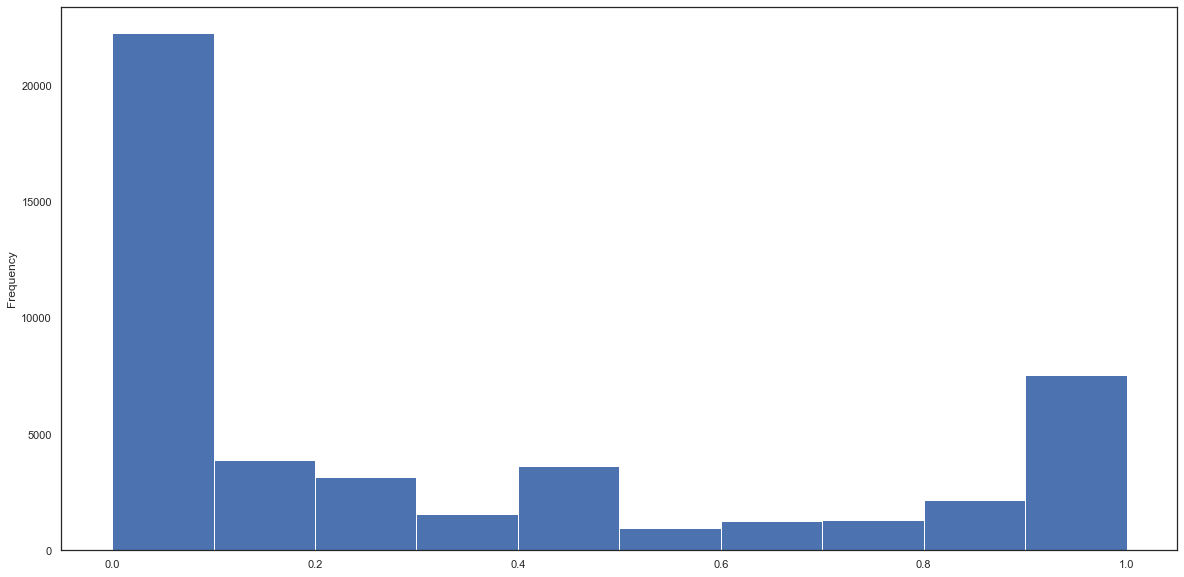

In [99]:
plt = listings_merge.available_year_avg.plot(kind='hist', figsize=(20, 10))

<br/>
<p>Even in a low season like winter, there seems to be low availability.</p>

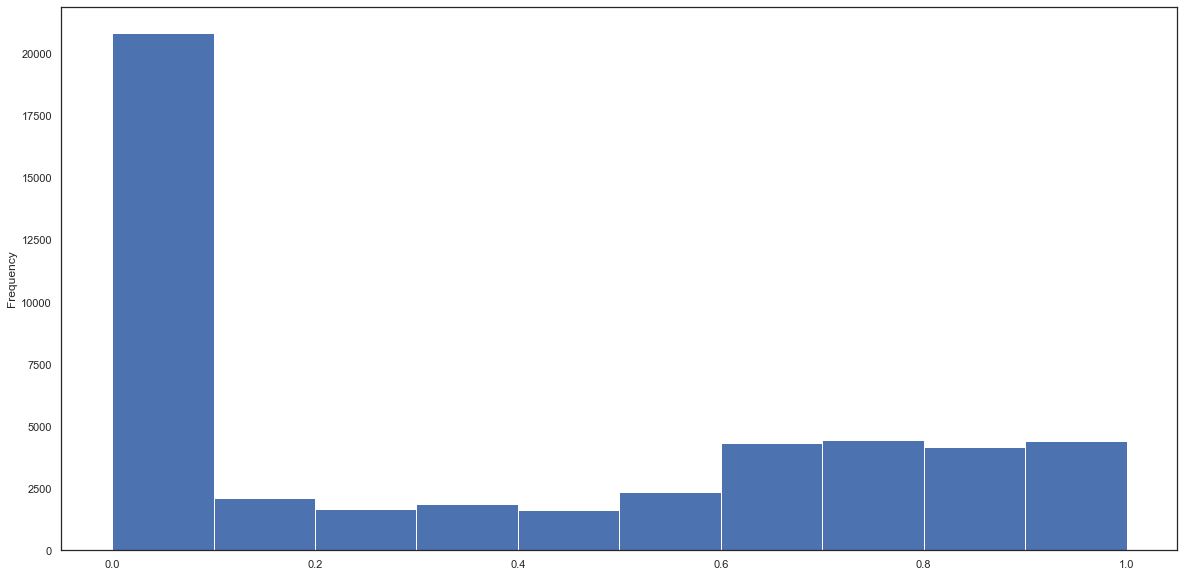

In [100]:
plt = listings_merge.available_winter_avg.plot(kind='hist', figsize=(20, 10))

<br/>
<p>Plotting the log of the minimum nights required we see that it approximates an exponential distribution.</p>

1.000000     11182
2.000000     10710
3.000000      7179
30.000000     3672
4.000000      3005
             ...  
1.339726         1
2.504110         1
6.580822         1
1.024658         1
21.005479        1
Name: min_nights_year_avg, Length: 1540, dtype: int64
30.000000    3672
7.000000     1882
6.000000      690
14.000000     508
10.000000     449
             ... 
28.002740       1
6.906849        1
28.884932       1
25.232877       1
5.778082        1
Name: min_nights_year_avg, Length: 666, dtype: int64


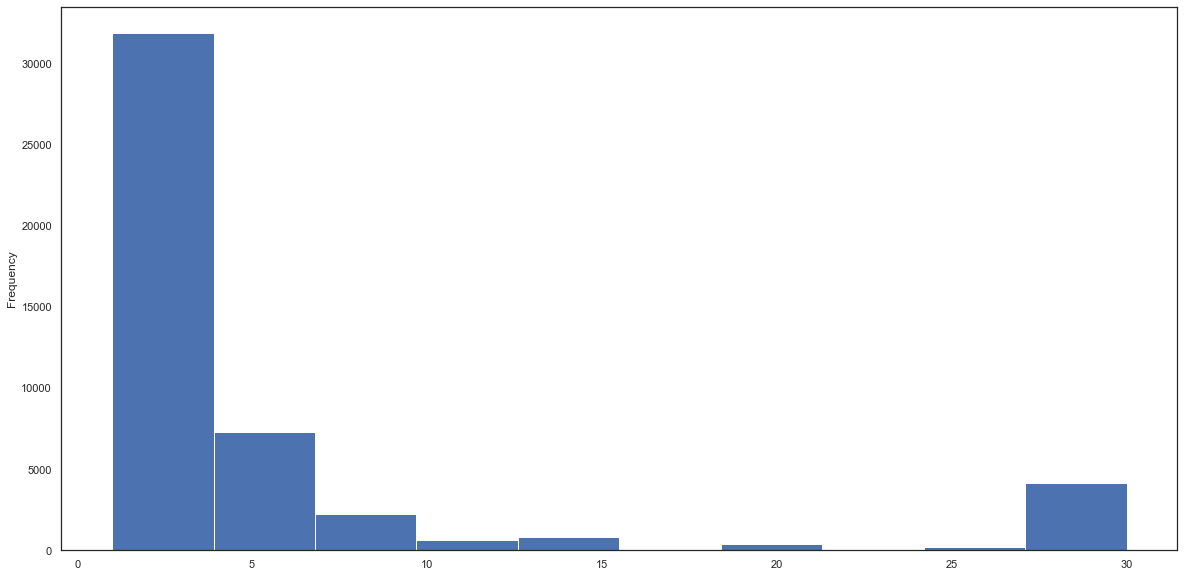

In [101]:
min_nights_75_perc = listings_merge.loc[listings_merge.min_nights_year_avg > 5].min_nights_year_avg.value_counts()
print(listings_merge.min_nights_year_avg.value_counts())
print(min_nights_75_perc)
plt = listings_merge.min_nights_year_avg.plot(kind='hist', figsize=(20, 10))

<br/>
<p>There isn't much detail in plot of average prices over the year.  We can't plot the log of average prices due to some zero values that need to be cleaned up.</p>

150.000000    899
100.000000    821
200.000000    677
50.000000     556
60.000000     526
             ... 
269.484932      1
120.035616      1
151.043836      1
134.956164      1
231.863014      1
Name: price_year_avg, Length: 23430, dtype: int64
200.000000    677
250.000000    452
300.000000    240
225.000000    169
350.000000    164
             ... 
378.767123      1
246.063014      1
501.484932      1
212.421918      1
601.479452      1
Name: price_year_avg, Length: 6885, dtype: int64


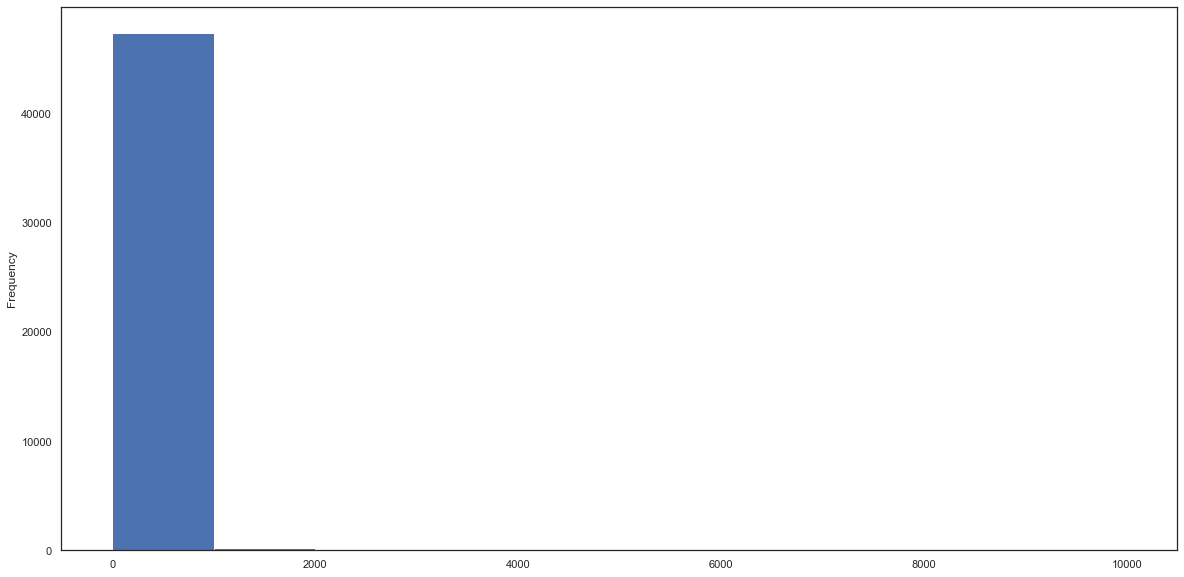

In [102]:
price_75_perc = listings_merge.loc[listings_merge.price_year_avg > 180].price_year_avg.value_counts()
print(listings_merge.price_year_avg.value_counts())
print(price_75_perc)
plt = listings_merge.price_year_avg.plot(kind='hist', figsize=(20, 10))

<br/>
<p>Use a similar method as with the <b>listings_clean</b> table to average over a 200 m radius from listings that have 0, missing, or outlier values for prices.</p>

In [106]:
print(listings_merge.columns)
print(
    listings_merge.columns[29], listings_merge.columns[30], listings_merge.columns[31],
    listings_merge.columns[32], listings_merge.columns[33], listings_merge.columns[34],
    listings_merge.columns[35], listings_merge.columns[36]
)

Index(['id', 'neighbourhood', 'neighbourhood_group', 'latitude', 'longitude',
       'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'no_reviews', 'few_reviews', 'many_reviews', 'available_year_avg',
       'available_winter_avg', 'available_spring_avg', 'available_summer_avg',
       'available_fall_avg', 'available_jan_avg', 'available_jun_avg',
       'available_dec_avg', 'min_nights_year_avg', 'min_nights_winter_avg',
       'min_nights_spring_avg', 'min_nights_summer_avg', 'min_nights_fall_avg',
       'min_nights_jan_avg', 'min_nights_jun_avg', 'min_nights_dec_avg',
       'price_year_avg', 'price_winter_avg', 'price_spring_avg',
       'price_summer_avg', 'price_fall_avg', 'price_jan_avg', 'price_jun_avg',
       'price_dec_avg'],
      dtype='object')
price_year_avg price_winter_avg price_spring_avg price_summer_avg price_fall_avg price_jan_avg price_jun_avg price_dec_avg


In [104]:
listings_merge.head()

,id,neighbourhood,neighbourhood_group,latitude,longitude,room_type,accommodates,bathrooms,bedrooms,beds,...,min_nights_jun_avg,min_nights_dec_avg,price_year_avg,price_winter_avg,price_spring_avg,price_summer_avg,price_fall_avg,price_jan_avg,price_jun_avg,price_dec_avg
0,2595,Midtown,Manhattan,40.75362,-73.98377,Entire home/apt,1,1.0,0.0,1.0,...,10.0,10.0,196.334247,177.255556,176.152174,215.728261,216.0,175.000000,215.1,181.548387
1,3831,Clinton Hill,Brooklyn,40.68514,-73.95976,Entire home/apt,3,1.0,1.0,4.0,...,1.0,1.0,86.224658,88.911111,86.032609,85.000000,85.0,86.516129,85.0,91.645161
2,5099,Murray Hill,Manhattan,40.74767,-73.97500,Entire home/apt,2,1.0,1.0,1.0,...,3.0,3.0,206.164384,225.000000,200.000000,200.000000,200.0,216.129032,200.0,256.451613
3,5121,Bedford-Stuyvesant,Brooklyn,40.68688,-73.95596,Private room,2,1.0,1.0,1.0,...,29.0,29.0,60.000000,60.000000,60.000000,60.000000,60.0,60.000000,60.0,60.000000
4,5178,Hell's Kitchen,Manhattan,40.76489,-73.98493,Private room,2,1.0,1.0,1.0,...,2.0,2.0,78.279452,77.233333,77.869565,79.000000,79.0,76.322581,79.0,79.000000


<br/>
<p>Similar to how we handled <b>bedrooms</b>, we will average price over 200m radius from listings that have 0 or NaN values.  We will also consider any listings with pricing over $1000 to be outliers, but instead of dropping them, we will also average over 200m radius.  Again we will not consider <b>room_type</b></p>

In [107]:
# https://gizmodo.com/how-precise-is-one-degree-of-longitude-or-latitude-1631241162
# averaging over approximate radius of 200 m from listings
# that have 0, NaN, or greater than threshold price values

lat_diff = 0.002
long_diff = 0.002
def avg_of_neighbors_2(row, col_name, col_index, thresh):
    item = row[col_index]
    room_type = row[5]
    lat = row[3]
    long = row[4]
#     if item == 0 or math.isnan(item)
    if math.isnan(item):
        item = listings_merge[col_name].loc[(listings_clean.latitude > lat - lat_diff) \
            & (listings_merge.latitude < lat + lat_diff) \
            & (listings_merge.longitude > long - long_diff) \
            & (listings_merge.longitude < long + long_diff)].groupby(by=listings_merge.neighbourhood).mean().round()[0]
        row[col_index] = item
    return row

listings_merge = listings_merge.apply(avg_of_neighbors_2, col_name='price_year_avg', col_index=29, axis=1, thresh=1000)
listings_merge = listings_merge.apply(avg_of_neighbors_2, col_name='price_winter_avg', col_index=30, axis=1, thresh=1000)
listings_merge = listings_merge.apply(avg_of_neighbors_2, col_name='price_spring_avg', col_index=31, axis=1, thresh=1000)
listings_merge = listings_merge.apply(avg_of_neighbors_2, col_name='price_summer_avg', col_index=32, axis=1, thresh=1000)
listings_merge = listings_merge.apply(avg_of_neighbors_2, col_name='price_fall_avg', col_index=33, axis=1, thresh=1000)
listings_merge = listings_merge.apply(avg_of_neighbors_2, col_name='price_jan_avg', col_index=34, axis=1, thresh=1000)
listings_merge = listings_merge.apply(avg_of_neighbors_2, col_name='price_jun_avg', col_index=35, axis=1, thresh=1000)
listings_merge = listings_merge.apply(avg_of_neighbors_2, col_name='price_dec_avg', col_index=36, axis=1, thresh=1000)


<br/>
<p>After some cleanup and taking the log of prices averaged over the year, we see an approximate normal distribution.</p>

150.000000    899
100.000000    821
200.000000    677
50.000000     556
60.000000     526
             ... 
269.484932      1
120.035616      1
151.043836      1
134.956164      1
231.863014      1
Name: price_year_avg, Length: 23430, dtype: int64


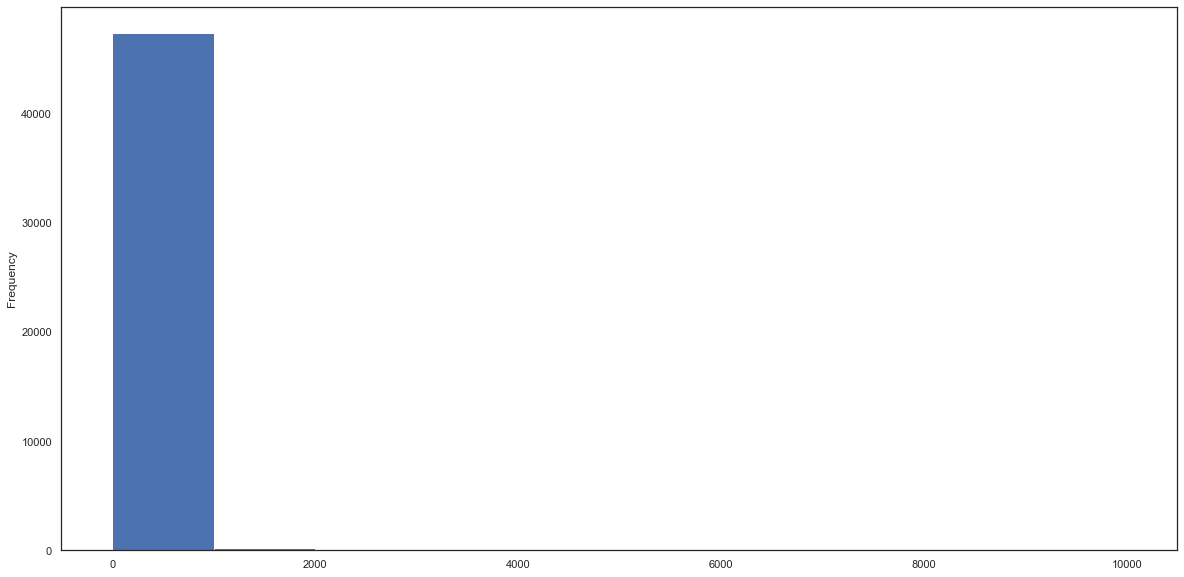

In [108]:
print(listings_merge.price_year_avg.value_counts())
plt = listings_merge.price_year_avg.plot(kind='hist', figsize=(20, 10))

<br/>
<p>Even after the cleaning process, we find that there is still a missing <b>price_fall_avg</b> value.  Averaging over nearest neighbors didn't catch everything!</p>

In [86]:
listings_merge.info()
listings_merge.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47725 entries, 0 to 48913
Data columns (total 37 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     47725 non-null  int64  
 1   neighbourhood          47725 non-null  object 
 2   neighbourhood_group    47725 non-null  object 
 3   latitude               47725 non-null  float64
 4   longitude              47725 non-null  float64
 5   room_type              47725 non-null  object 
 6   accommodates           47725 non-null  int64  
 7   bathrooms              47725 non-null  float64
 8   bedrooms               47723 non-null  float64
 9   beds                   47724 non-null  float64
 10  no_reviews             47725 non-null  int64  
 11  few_reviews            47725 non-null  int64  
 12  many_reviews           47725 non-null  int64  
 13  available_year_avg     47725 non-null  float64
 14  available_winter_avg   47725 non-null  float64
 15  av

,id,latitude,longitude,accommodates,bathrooms,bedrooms,beds,no_reviews,few_reviews,many_reviews,...,min_nights_jun_avg,min_nights_dec_avg,price_year_avg,price_winter_avg,price_spring_avg,price_summer_avg,price_fall_avg,price_jan_avg,price_jun_avg,price_dec_avg
count,4.772500e+04,47725.000000,47725.000000,47725.000000,47725.000000,47723.000000,47724.000000,47725.0,47725.000000,47725.000000,...,47725.000000,47725.000000,47725.000000,47725.000000,47723.000000,47725.000000,47722.000000,47723.000000,47725.000000,47725.000000
mean,2.109746e+07,40.728508,-73.950567,2.899109,1.144767,1.186640,1.549682,0.0,0.679749,0.127878,...,5.612433,5.552657,156.137808,149.882138,155.224398,157.513144,161.860831,146.522014,158.010587,156.323679
std,1.241537e+07,0.055076,0.047742,1.913284,0.425164,0.769513,1.127175,0.0,0.466578,0.333958,...,8.191771,8.072077,236.850552,228.726010,236.892485,234.135567,292.857878,228.651706,235.008400,234.764691
min,2.595000e+03,40.499790,-74.247870,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.935888e+06,40.689150,-73.982630,2.000000,1.000000,1.000000,1.000000,0.0,0.000000,0.000000,...,1.300000,1.516129,70.000000,69.000000,70.000000,70.000000,70.000000,68.000000,70.000000,70.000000
50%,2.117401e+07,40.722360,-73.954840,2.000000,1.000000,1.000000,1.000000,0.0,1.000000,0.000000,...,2.733333,2.677419,110.000000,107.733333,110.000000,110.000000,110.000000,105.000000,110.000000,110.258065
75%,3.231064e+07,40.762990,-73.934100,4.000000,1.000000,1.000000,2.000000,0.0,1.000000,0.000000,...,5.000000,5.000000,180.000000,175.000000,179.782609,180.000000,180.000000,170.000000,180.000000,180.000000
max,4.058402e+07,40.916860,-73.712990,25.000000,15.500000,21.000000,40.000000,0.0,1.000000,1.000000,...,30.000000,30.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000


In [109]:
listings_merge_backup = listings_merge

In [110]:
listings_merge = listings_merge_backup

<p>Drop non-numerical columns as well as listing IDs (which do not have any meaning for modeling).</p>

In [111]:
neighbourhood_group_one_hot = pd.get_dummies(listings_merge.neighbourhood_group)
listings_merge = listings_merge.join(neighbourhood_group_one_hot)
listings_merge['entire_home_apt'] = np.where(listings_merge.room_type == 'Entire home/apt', 1, 0)

listings_merge = listings_merge.drop([
    'id', 'room_type', 'neighbourhood', 'neighbourhood_group'
], axis=1)


In [112]:
listings_merge.no_reviews.value_counts()

0    47725
Name: no_reviews, dtype: int64

<br/>
<p>Let's do a final check for any correlated features.</p>

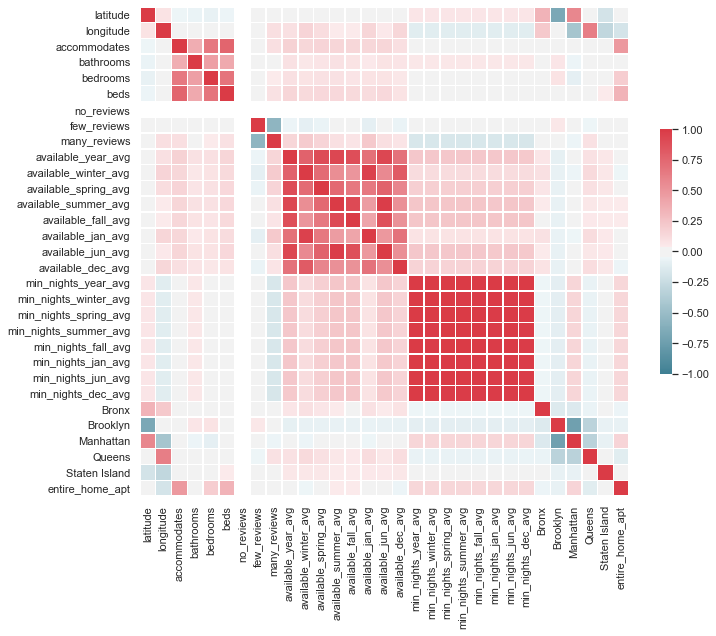

In [113]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

features = listings_merge.drop([
    'price_year_avg', 'price_winter_avg', 'price_spring_avg', 'price_summer_avg', 'price_fall_avg',
    'price_jan_avg', 'price_jun_avg', 'price_dec_avg'
], axis=1)

fig, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(features.corr(), cmap=cmap, vmax=1, vmin=-1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

<p>We can see that <b>beds</b> and <b>accommodates</b> are heavily correlated with <b>bedrooms</b>.  We can drop those columns.</p>

In [92]:
listings_merge = listings_merge.drop(['beds', 'accommodates'], axis=1)

<p>Perhaps we can add more features like monthly or holiday averages for availability, minimum nights required, and price, but that would make the table size explode!<p>

<h2>Modeling data with prices as target labels</h2>

<p>Now that we've cleaned up the data, let's look at several possible models of linear and non-linear type.  We will use average price of each listing over the year 2019, as well as seasonal average price as the target labels.  The easiest ones to get started with are Linear Regression and Random Forest.</p>

In [114]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_base = listings_merge.drop([
    'price_year_avg', 'price_winter_avg', 'price_spring_avg', 'price_summer_avg', 'price_fall_avg',
    'price_jan_avg', 'price_jun_avg', 'price_dec_avg',
    'available_year_avg', 'available_winter_avg', 'available_spring_avg', 'available_summer_avg',
    'available_fall_avg', 'available_jan_avg', 'available_jun_avg', 'available_dec_avg',
    'min_nights_year_avg', 'min_nights_winter_avg', 'min_nights_spring_avg', 'min_nights_summer_avg',
    'min_nights_fall_avg', 'min_nights_jan_avg', 'min_nights_jun_avg', 'min_nights_dec_avg',
], axis=1)
combo_list = [
    ['available_year_avg', 'min_nights_year_avg', 'price_year_avg'],
    ['available_winter_avg', 'min_nights_winter_avg', 'price_winter_avg'],
    ['available_spring_avg', 'min_nights_spring_avg', 'price_spring_avg'],
    ['available_summer_avg', 'min_nights_summer_avg', 'price_summer_avg'],
    ['available_fall_avg', 'min_nights_fall_avg', 'price_fall_avg'],
    ['available_jan_avg', 'min_nights_jan_avg', 'price_jan_avg'],
    ['available_jun_avg', 'min_nights_jun_avg', 'price_jun_avg'],
    ['available_dec_avg', 'min_nights_dec_avg', 'price_dec_avg']
]

scaler = StandardScaler()

for combo in combo_list:
    y = listings_merge[combo[2]]
    X_temp = X_base
    X_temp[combo[0]] = listings_merge[combo[0]]
    X_temp[combo[1]] = listings_merge[combo[1]]
    
    X_train, X_test, y_train, y_test = train_test_split(X_temp, y, test_size=.25, random_state=42, shuffle=True)
    print('Target label:', combo[2])

#     clf = LinearRegression()
#     clf.fit(scaler.fit_transform(X_train), y_train)
#     print("Linear regression score:", clf.score(scaler.transform(X_test), y_test))
#     clf2 = RandomForestRegressor()
#     clf2.fit(scaler.fit_transform(X_train), y_train)
#     print("Random forest score:", clf2.score(scaler.transform(X_test), y_test))
    
    clf = LinearRegression()
    clf.fit(X_train, y_train)
    print("Linear regression score:", clf.score(X_test, y_test))
    clf2 = RandomForestRegressor()
    clf2.fit(X_train, y_train)
    print("Random forest score:", clf2.score(X_test, y_test))

Target label: price_year_avg


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

<p>We can see that Random Forest performs much better than Linear Regression in terms of R<sup>2</sup> score.</p>

<br/>
<p>Try optimizing some of the parameters using GridSearchCV.</p>

In [65]:
print(clf2.base_estimator_)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')


In [ ]:
from sklearn.model_selection import GridSearchCV

X = listings_merge.drop([
    'price_year_avg', 'price_winter_avg', 'price_spring_avg', 'price_summer_avg', 'price_fall_avg',
    'available_winter_avg', 'available_spring_avg', 'available_summer_avg', 'available_fall_avg',
    'min_nights_winter_avg', 'min_nights_spring_avg', 'min_nights_summer_avg', 'min_nights_fall_avg'
], axis=1)

y = listings_merge['price_year_avg']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42, shuffle=True)
clf = RandomForestRegressor()

params = {
    'max_depth': [6, 8, 10, 12],
    'min_samples_split': [4, 8, 16],
    'min_samples_leaf': [4, 8, 16],
    'max_features': [2, 4, 6]
}
grid = GridSearchCV(clf, param_grid=params, cv=5, scoring='r2')
grid.fit(X_train, y_train)
print(grid.best_score_)
print(grid.best_params_)

In [ ]:
X_base = listings_merge.drop([
    'price_year_avg', 'price_winter_avg', 'price_spring_avg', 'price_summer_avg', 'price_fall_avg',
    'available_year_avg', 'available_winter_avg', 'available_spring_avg', 'available_summer_avg',
    'available_fall_avg',
    'min_nights_year_avg', 'min_nights_winter_avg', 'min_nights_spring_avg', 'min_nights_summer_avg',
    'min_nights_fall_avg'
], axis=1)
combo_list = [
    ['available_year_avg', 'min_nights_year_avg', 'price_year_avg'],
    ['available_winter_avg', 'min_nights_winter_avg', 'price_winter_avg'],
    ['available_spring_avg', 'min_nights_spring_avg', 'price_spring_avg'],
    ['available_summer_avg', 'min_nights_summer_avg', 'price_summer_avg'],
    ['available_fall_avg', 'min_nights_fall_avg', 'price_fall_avg']
]
best_params = grid.best_params_

for combo in combo_list:
    y = listings_merge[combo[2]]
    X_temp = X_base
    X_temp[combo[0]] = listings_merge[combo[0]]
    X_temp[combo[1]] = listings_merge[combo[1]]
    
    X_train, X_test, y_train, y_test = train_test_split(X_temp, y, test_size=.25, random_state=42, shuffle=True)

    clf = RandomForestRegressor(
        max_depth=best_params['max_depth'],
        max_features=best_params['max_features'],
        min_samples_leaf=best_params['min_samples_leaf'],
        min_samples_split=best_params['min_samples_split']
    )
    clf.fit(X_train, y_train)
    print('Target label:', combo[2])
    print('Modified param random forest score:', clf.score(X_test, y_test))


<p>Our modified parameter Random Forest scores are essentially no better than with default parameters.</p>

<p>Perhaps there will be an incremental improvement in R<sup>2</sup> by using Gradient Boosting (XGBoost in this case).</p>

In [58]:
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import train_test_split

X_base = listings_merge.drop([
    'price_year_avg', 'price_winter_avg', 'price_spring_avg', 'price_summer_avg', 'price_fall_avg',
    'price_jan_avg', 'price_jun_avg', 'price_dec_avg',
    'available_year_avg', 'available_winter_avg', 'available_spring_avg', 'available_summer_avg',
    'available_fall_avg', 'available_jan_avg', 'available_jun_avg', 'available_dec_avg',
    'min_nights_year_avg', 'min_nights_winter_avg', 'min_nights_spring_avg', 'min_nights_summer_avg',
    'min_nights_fall_avg', 'min_nights_jan_avg', 'min_nights_jun_avg', 'min_nights_dec_avg',
], axis=1)
combo_list = [
#     ['available_year_avg', 'min_nights_year_avg', 'price_year_avg'],
#     ['available_winter_avg', 'min_nights_winter_avg', 'price_winter_avg'],
#     ['available_spring_avg', 'min_nights_spring_avg', 'price_spring_avg'],
#     ['available_summer_avg', 'min_nights_summer_avg', 'price_summer_avg'],
#     ['available_fall_avg', 'min_nights_fall_avg', 'price_fall_avg'],
    ['available_jan_avg', 'min_nights_jan_avg', 'price_jan_avg'],
    ['available_jun_avg', 'min_nights_jun_avg', 'price_jun_avg'],
    ['available_dec_avg', 'min_nights_dec_avg', 'price_dec_avg']
]

for combo in combo_list:
    y = listings_merge[combo[2]]
    X_temp = X_base
    X_temp[combo[0]] = listings_merge[combo[0]]
    X_temp[combo[1]] = listings_merge[combo[1]]
    
    X_train, X_test, y_train, y_test = train_test_split(X_temp, y, test_size=.25, random_state=42, shuffle=True)

    clf = XGBRegressor(
        objective='reg:squarederror',
        learning_rate=0.1,
        max_depth=8,
        n_estimators=200,
        cv=5
    )

#     clf.fit(scaler.fit_transform(X_train), y_train)
#     print('Target label:', combo[2])
#     print('XGBoost score:', clf.score(scaler.transform(X_test), y_test))

    clf.fit(X_train, y_train)
    print('Target label:', combo[2])
    print('XGBoost score:', clf.score(X_test, y_test))

Target label: price_jan_avg
XGBoost score: 0.4898960528591744
Target label: price_jun_avg
XGBoost score: 0.5664017821663974
Target label: price_dec_avg
XGBoost score: 0.5664694063536269


<p>We get decent scores from a Gradient Boost model.</p>

<p>Will polynomial regression provide any benefit?  Let's find out.</p>

In [76]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

X_base = listings_merge.drop([
    'price_year_avg', 'price_winter_avg', 'price_spring_avg', 'price_summer_avg', 'price_fall_avg',
    'price_jan_avg', 'price_jun_avg', 'price_dec_avg',
    'available_year_avg', 'available_winter_avg', 'available_spring_avg', 'available_summer_avg',
    'available_fall_avg', 'available_jan_avg', 'available_jun_avg', 'available_dec_avg',
    'min_nights_year_avg', 'min_nights_winter_avg', 'min_nights_spring_avg', 'min_nights_summer_avg',
    'min_nights_fall_avg', 'min_nights_jan_avg', 'min_nights_jun_avg', 'min_nights_dec_avg',
], axis=1)
combo_list = [
#     ['available_year_avg', 'min_nights_year_avg', 'price_year_avg'],
#     ['available_winter_avg', 'min_nights_winter_avg', 'price_winter_avg'],
#     ['available_spring_avg', 'min_nights_spring_avg', 'price_spring_avg'],
#     ['available_summer_avg', 'min_nights_summer_avg', 'price_summer_avg'],
#     ['available_fall_avg', 'min_nights_fall_avg', 'price_fall_avg'],
    ['available_jan_avg', 'min_nights_jan_avg', 'price_jan_avg'],
    ['available_jun_avg', 'min_nights_jun_avg', 'price_jun_avg'],
    ['available_dec_avg', 'min_nights_dec_avg', 'price_dec_avg']
]

for combo in combo_list:
    y = listings_merge[combo[2]]
    X_temp = X_base
    X_temp[combo[0]] = listings_merge[combo[0]]
    X_temp[combo[1]] = listings_merge[combo[1]]
    
    X_train, X_test, y_train, y_test = train_test_split(X_temp, y, test_size=.25, random_state=42, shuffle=True)

    poly = PolynomialFeatures(degree=2)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)
    
    clf = LinearRegression()
    clf.fit(X_train_poly, y_train)
    print('Target label:', combo[2])
    print(clf.score(X_test_poly, y_test))

Target label: price_jan_avg
0.47353041594664486
Target label: price_jun_avg
0.5206383172409412
Target label: price_dec_avg
0.5211448769117493


In [75]:
from sklearn.preprocessing import PolynomialFeatures
from xgboost.sklearn import XGBRegressor

X_base = listings_merge.drop([
    'price_year_avg', 'price_winter_avg', 'price_spring_avg', 'price_summer_avg', 'price_fall_avg',
    'price_jan_avg', 'price_jun_avg', 'price_dec_avg',
    'available_year_avg', 'available_winter_avg', 'available_spring_avg', 'available_summer_avg',
    'available_fall_avg', 'available_jan_avg', 'available_jun_avg', 'available_dec_avg',
    'min_nights_year_avg', 'min_nights_winter_avg', 'min_nights_spring_avg', 'min_nights_summer_avg',
    'min_nights_fall_avg', 'min_nights_jan_avg', 'min_nights_jun_avg', 'min_nights_dec_avg',
], axis=1)
combo_list = [
#     ['available_year_avg', 'min_nights_year_avg', 'price_year_avg'],
#     ['available_winter_avg', 'min_nights_winter_avg', 'price_winter_avg'],
#     ['available_spring_avg', 'min_nights_spring_avg', 'price_spring_avg'],
#     ['available_summer_avg', 'min_nights_summer_avg', 'price_summer_avg'],
#     ['available_fall_avg', 'min_nights_fall_avg', 'price_fall_avg'],
    ['available_jan_avg', 'min_nights_jan_avg', 'price_jan_avg'],
    ['available_jun_avg', 'min_nights_jun_avg', 'price_jun_avg'],
    ['available_dec_avg', 'min_nights_dec_avg', 'price_dec_avg']
]

for combo in combo_list:
    y = listings_merge[combo[2]]
    X_temp = X_base
    X_temp[combo[0]] = listings_merge[combo[0]]
    X_temp[combo[1]] = listings_merge[combo[1]]
    
    X_train, X_test, y_train, y_test = train_test_split(X_temp, y, test_size=.25, random_state=42, shuffle=True)

    poly = PolynomialFeatures(degree=2)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)
    
    clf = XGBRegressor(
        objective='reg:squarederror',
        learning_rate=0.1,
        max_depth=8,
        n_estimators=100,      
    )
    clf.fit(X_train_poly, y_train)
    print('Target label:', combo[2])
    print(clf.score(X_test_poly, y_test))

/Users/blai/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Target label: price_jan_avg
0.5433020255704233


/Users/blai/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Target label: price_jun_avg
0.6133626385054366


/Users/blai/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Target label: price_dec_avg
0.622320729995511


<p>It's odd that the fall price average model has such a terrible score compared to the rest for second degree Polynomial Feature Transform + Linear Regresssion.  Second degree Polynomial Feature Transform + Gradient Boosting performs close but no better than Gradient Boosting alone.</p>